In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd

from text_classification.utils.train_evaluate import Trainer
from text_classification.models.TextCNN import TextCNN
from text_classification.data_ag_news.data.data_process_glove import DataProcess

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dp = DataProcess('../datasets/train.csv', '../datasets/test.csv', device)
train_loader, test_loader = dp.get_dataLoader(141)
pre_vector = dp.get_pre_trained("glove.6B.50d.txt", '../../extra/glove_vector/')
print(pre_vector.shape)

torch.Size([95812, 50])


In [3]:
model = TextCNN(4, pre_vector.shape[0], pre_vector.shape[1], (3, 4, 5), (100, 100, 100))
model.embedding.weight.data.copy_(pre_vector)
model.constant_embedding.weight.data.copy_(pre_vector)  # 使用模型预训练词向量矩阵
model.constant_embedding.weight.requires_grad = False  # 冻结网络层,使之不参与训练
model = model.to(device)

epochs = 1
lr = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [4]:
def compute_metrics_f1(predict_all, y_true):
    """计算模型f1 score"""
    predict = predict_all.argmax(-1)
    label = y_true
    acc = f1_score(label, predict, average='micro')
    return {"f1": acc}


t_and_v = Trainer(model=model, optimizer=optimizer, criterion=criterion, epochs=epochs)

metric_result = t_and_v.train(train_loader=train_loader, valid_loader=test_loader, compute_metrics=compute_metrics_f1)
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.index.name = 'epoch'
metric_result_df

Train Epoch: 0  [0    /120000 (0  %)]	Loss: 1.457156	f1: 0.187500
Train Epoch: 0  [320  /120000 (0  %)]	Loss: 1.385129	f1: 0.312500
Train Epoch: 0  [640  /120000 (1  %)]	Loss: 1.493145	f1: 0.312500
Train Epoch: 0  [960  /120000 (1  %)]	Loss: 1.142711	f1: 0.562500
Train Epoch: 0  [1280 /120000 (1  %)]	Loss: 0.948963	f1: 0.687500
Train Epoch: 0  [1600 /120000 (1  %)]	Loss: 1.054251	f1: 0.750000
Train Epoch: 0  [1920 /120000 (2  %)]	Loss: 1.016721	f1: 0.500000
Train Epoch: 0  [2240 /120000 (2  %)]	Loss: 1.228390	f1: 0.375000
Train Epoch: 0  [2560 /120000 (2  %)]	Loss: 0.992222	f1: 0.562500
Train Epoch: 0  [2880 /120000 (2  %)]	Loss: 0.972247	f1: 0.625000
Train Epoch: 0  [3200 /120000 (3  %)]	Loss: 0.692361	f1: 0.750000
Train Epoch: 0  [3520 /120000 (3  %)]	Loss: 0.717343	f1: 0.937500
Train Epoch: 0  [3840 /120000 (3  %)]	Loss: 0.723043	f1: 0.812500
Train Epoch: 0  [4160 /120000 (3  %)]	Loss: 0.635339	f1: 0.750000
Train Epoch: 0  [4480 /120000 (4  %)]	Loss: 0.892998	f1: 0.562500
Train Epoc

,Training loss,Training f1,Validation loss,Validation f1
epoch,,,,
0,0.298727,0.898483,0.313532,0.892763


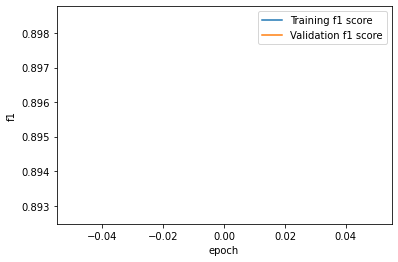

In [5]:
plt.plot(metric_result['Training f1'], label='Training f1 score')
plt.plot(metric_result['Validation f1'], label='Validation f1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend()
plt.show()
